# High level insights regarding count vectorizer

## 'linear_model_with_bow.pkl' and 'vectorizer.pkl'

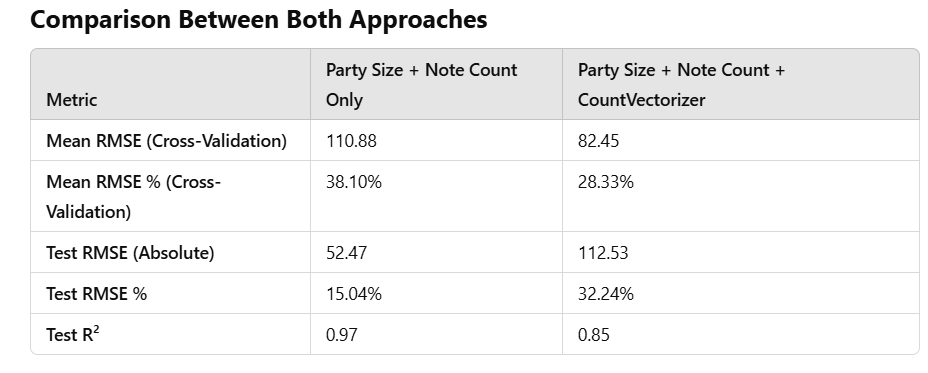

Model and vectorizer saved as 'linear_model_with_bow.pkl' and 'vectorizer.pkl'.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

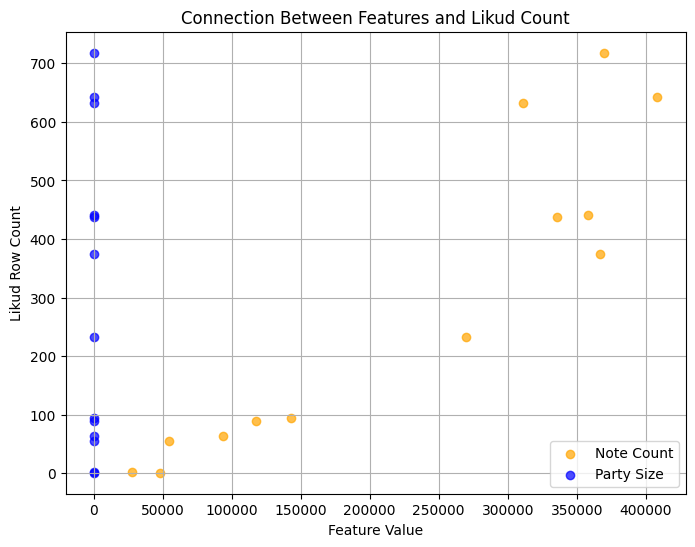

{'Mean RMSE (Cross-Validation)': '84.26', 'Mean RMSE Percentage (Cross-Validation)': '28.95%', 'Test RMSE (Absolute)': '113.61', 'Test RMSE Percentage': '32.55%', 'Test R²': '0.85'}


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load the dataset
original_data_path = 'processed_combined_data.csv'  # Replace with actual path
data = pd.read_csv(original_data_path)

# Define party sizes (example mandates, update as needed)
party_sizes = {
    'הליכוד': 30,
    'יש עתיד': 17,
    'ש״ס': 9,
    'כחול לבן': 8,
    'ימינה': 7,
    'העבודה': 7,
    'יהדות התורה': 7,
    'ישראל ביתנו': 7,
    'הציונות הדתית': 6,
    'הרשימה המשותפת': 6,
    'תקווה חדשה': 6,
    'מרצ': 6,
    'הרשימה הערבית המאוחדת': 4
}

# Add `note_count` and `party_size` features
data['note_count'] = data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
data['party_size'] = data['party'].map(party_sizes).fillna(0).astype(int)

# Preprocess text for CountVectorizer
data['text'] = data['text'].fillna('').str.replace(r'[^א-ת\s]', '', regex=True)  # Remove non-Hebrew characters

# Initialize and fit CountVectorizer
vectorizer = CountVectorizer(max_features=1000)  # Limit vocabulary size to 1000 most frequent words
text_features = vectorizer.fit_transform(data['text']).toarray()

# Convert text features to a DataFrame and add session/party columns
text_features_df = pd.DataFrame(text_features, columns=vectorizer.get_feature_names_out())
text_features_df = pd.concat([data[['session', 'party']].reset_index(drop=True), text_features_df.reset_index(drop=True)], axis=1)

# Aggregate text features by session
text_features_aggregated = text_features_df.groupby('session').sum().reset_index()

# Aggregate note_count and party_size at the session level
session_features = data.groupby('session').agg({
    'note_count': 'sum',  # Total note count for the session
    'party_size': 'max',  # Max party size (Likud size)
}).reset_index()

# Merge aggregated text features with session-level features
session_features = session_features.merge(text_features_aggregated, on='session', how='left')

# Calculate the target (Likud count per session)
likud_rows = data[data['party'] == 'הליכוד']
true_counts = likud_rows.groupby('session').size().reset_index(name='count')

# Merge aggregated features with the target
training_data = session_features.merge(true_counts, on='session', how='left')
training_data['count'] = training_data['count'].fillna(0).astype(int)

# Add stratification bins for target variable
training_data['count_bin'] = pd.qcut(training_data['count'], q=2, labels=False)

# Define features (X) and target (y)
X = training_data.drop(columns=['session', 'count', 'count_bin'])  # Exclude session, count, and bins from features
X = X.select_dtypes(include=[np.number])  # Ensure only numeric columns are included
y = training_data['count']

# Train-test split with stratified bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=training_data['count_bin']
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the model and vectorizer
with open('linear_model_with_bow.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

print("Model and vectorizer saved as 'linear_model_with_bow.pkl' and 'vectorizer.pkl'.")

# Cross-validation with Stratified K-Fold
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_scores = []
for train_idx, test_idx in strat_kfold.split(X, training_data['count_bin']):
    X_cv_train, X_cv_test = X.iloc[train_idx], X.iloc[test_idx]
    y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the model on the fold
    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_cv_test, y_cv_pred, squared=False)
    cv_rmse_scores.append(rmse)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
mean_rmse_cv = np.mean(cv_rmse_scores)
mean_rmse_cv_percentage = (mean_rmse_cv / y.mean()) * 100
rmse_test_percentage = (rmse_test / y_test.mean()) * 100

# Plot: Connection between note_count, party_size, and count
plt.figure(figsize=(8, 6))
plt.scatter(training_data['note_count'], training_data['count'], alpha=0.7, label='Note Count', color='orange')
plt.scatter(training_data['party_size'], training_data['count'], alpha=0.7, label='Party Size', color='blue')
plt.title("Connection Between Features and Likud Count")
plt.xlabel("Feature Value")
plt.ylabel("Likud Row Count")
plt.legend()
plt.grid()
plt.show()

# Display metrics
metrics = {
    "Mean RMSE (Cross-Validation)": f"{mean_rmse_cv:.2f}",
    "Mean RMSE Percentage (Cross-Validation)": f"{mean_rmse_cv_percentage:.2f}%",
    "Test RMSE (Absolute)": f"{rmse_test:.2f}",
    "Test RMSE Percentage": f"{rmse_test_percentage:.2f}%",
    "Test R²": f"{r2_test:.2f}"
}
print(metrics)


________________________________________

__________________________________________________________

## Linear Regression with TF-IDF + party_size + note_count

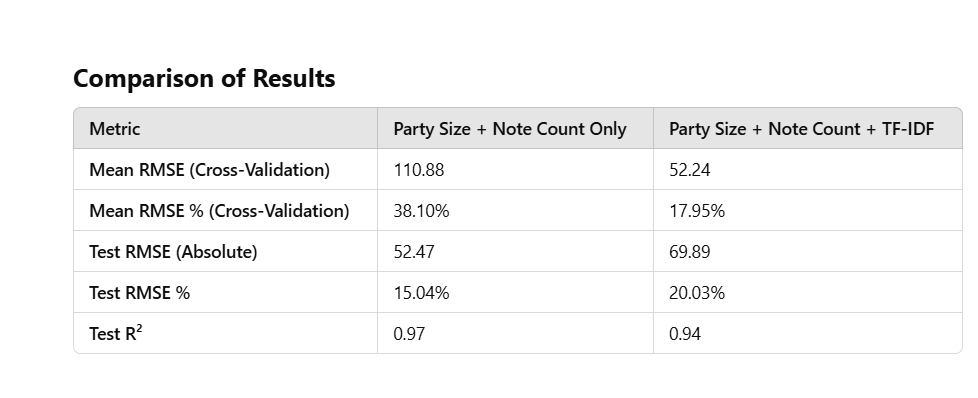

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.sparse import hstack
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Load the original dataset
original_data_path = 'processed_combined_data.csv'  # Replace with actual path
data = pd.read_csv(original_data_path)

# Define party sizes (example mandates, update as needed)
party_sizes = {
    'הליכוד': 30,
    'יש עתיד': 17,
    'ש״ס': 9,
    'כחול לבן': 8,
    'ימינה': 7,
    'העבודה': 7,
    'יהדות התורה': 7,
    'ישראל ביתנו': 7,
    'הציונות הדתית': 6,
    'הרשימה המשותפת': 6,
    'תקווה חדשה': 6,
    'מרצ': 6,
    'הרשימה הערבית המאוחדת': 4
}

# Add `note_count` and `party_size` features
data['note_count'] = data['text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
data['party_size'] = data['party'].map(party_sizes).fillna(0).astype(int)

# Preprocess text for TF-IDF
data['text'] = data['text'].fillna('').str.replace(r'[^א-ת\s]', '', regex=True)

# Extract text features using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=500,  # Limit to top 500 words
    min_df=3,          # Remove words appearing in fewer than 3 documents
    max_df=0.85,       # Remove overly common words
    ngram_range=(1, 2)  # Include unigrams and bigrams
)
text_features = vectorizer.fit_transform(data['text'])

# Aggregate numerical features at the session level
session_features = data.groupby('session').agg({
    'note_count': 'sum',  # Total note count for the session
    'party_size': 'max',  # Max party size (Likud size)
}).reset_index()

# Scale numerical features
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(session_features[['note_count', 'party_size']])

# Aggregate TF-IDF features by session
text_features_df = pd.DataFrame(text_features.toarray(), columns=vectorizer.get_feature_names_out())
text_features_df['session'] = data['session'].reset_index(drop=True)
text_features_aggregated = text_features_df.groupby('session').sum().reset_index()

# Ensure session alignment
scaled_numerical_features_df = pd.DataFrame(
    scaled_numerical_features,
    columns=['note_count_scaled', 'party_size_scaled']
)
scaled_numerical_features_df['session'] = session_features['session']

# Merge aggregated numerical and text features on 'session'
combined_features_df = pd.merge(
    scaled_numerical_features_df,
    text_features_aggregated,
    on='session'
)

# Remove session column and prepare combined features
combined_features = combined_features_df.drop(columns=['session']).values

# Calculate the target (Likud count per session)
likud_rows = data[data['party'] == 'הליכוד']
true_counts = likud_rows.groupby('session').size().reset_index(name='count')

# Merge aggregated features with the target
training_data = session_features.merge(true_counts, on='session', how='left')
training_data['count'] = training_data['count'].fillna(0).astype(int)

# Add stratification bins for target variable
training_data['count_bin'] = pd.qcut(training_data['count'], q=2, labels=False)

# Define features (X) and target (y)
y = training_data['count']
X = combined_features

# Train-test split with stratified bins
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=training_data['count_bin']
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Save the model, vectorizer, and scaler
with open('linear_model_with_tfidf.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Model, vectorizer, and scaler saved.")

# Evaluate the model using cross-validation
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_scores = []
for train_idx, test_idx in strat_kfold.split(X, training_data['count_bin']):
    X_cv_train, X_cv_test = X[train_idx], X[test_idx]
    y_cv_train, y_cv_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_test)
    rmse = mean_squared_error(y_cv_test, y_cv_pred, squared=False)
    cv_rmse_scores.append(rmse)

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)
mean_rmse_cv = np.mean(cv_rmse_scores)
mean_rmse_cv_percentage = (mean_rmse_cv / y.mean()) * 100
rmse_test_percentage = (rmse_test / y_test.mean()) * 100

# Display metrics
metrics = {
    "Mean RMSE (Cross-Validation)": f"{mean_rmse_cv:.2f}",
    "Mean RMSE Percentage (Cross-Validation)": f"{mean_rmse_cv_percentage:.2f}%",
    "Test RMSE (Absolute)": f"{rmse_test:.2f}",
    "Test RMSE Percentage": f"{rmse_test_percentage:.2f}%",
    "Test R²": f"{r2_test:.2f}"
}
print(metrics)


Model, vectorizer, and scaler saved.
{'Mean RMSE (Cross-Validation)': '52.24', 'Mean RMSE Percentage (Cross-Validation)': '17.95%', 'Test RMSE (Absolute)': '69.89', 'Test RMSE Percentage': '20.03%', 'Test R²': '0.94'}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo